# Generating Figure 2b,c: Fitting Sigmoid Curve To (m/h)IL-17A and Fc-(m/h)IL-17A Dose Response For Pharmacodynamics Analysis

Updated: 24/04/05

## One Parameter $E_{max}$ model
$$ \text{Activity(B(t))=} \frac{1}{1 + 10^{-(log_{10}(B(t))-log_{10}(EC_{50}))} }$$

1. We used the one parameter model for fit our data to determine the pharmacodynamics of each of the proteins in the context of the IL-6 test. 
2. We determined the EC50s of each molecule
3. We will take this pharmacodynamics model for PK/PD calculations in subsequent notebooks

In [3]:
import numpy as np
import pylab
from scipy.optimize import curve_fit
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os as os


## Define Context for Sizes
sns.set(font='Helvetica Neue',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'k',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'k',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'k',
 'xtick.bottom': True,
 'xtick.minor.visible': True,
 'xtick.color': 'k',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.minor.visible': True,
 'ytick.color': 'k',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})

sns.set_context("paper", rc={"font.size":12,
                             "axes.titlesize":16,
                             "axes.labelsize":16,
                             "xtick.labelsize":14,
                             "ytick.labelsize":14,
                            },font_scale=2)


import matplotlib.ticker as ticker

def apply_log_scale_with_custom_ticks(ax):
    """Apply log scale and custom tick settings to the given axes."""
    # Set major locator
    x_major = ticker.LogLocator(base=10.0, numticks=10)
    ax.xaxis.set_major_locator(x_major)
    
    # Set minor locator without labels
    x_minor = ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())



## Data File Location
working_path = '/Users/qiuwu/Dropbox (HMS)/Important Documents in Graduate School/Shared_Qiu/FC Fusion Paper/'
   
figure_path = 'Figures/Figure_2_data/'
data_path = 'IL17_Dose_Responses.xlsx'
data_file = working_path+figure_path+data_path


save_figures_path = "/Figures/raw_figures/figure 2/"



### Log10 transformed data

In [8]:
data_df = pd.read_excel(data_file)
data_df.loc[:,'Log_Dose'] = np.round(np.log10(data_df.Dosage+1e-3),3)
data_df.tail(5)

,EXP #,Species,Molecule,Dosage,FC,Min Max,Log_Dose
135,EXP_0062,Murine,FC IL-17,57.142857,NaN,1.000007,1.757
136,EXP_0062,Murine,FC IL-17,57.142857,NaN,1.000012,1.757
137,EXP_0062,Murine,FC IL-17,57.142857,NaN,1.000006,1.757
138,EXP_0062,Human,FC IL-17,57.736721,NaN,1.000022,1.761
139,EXP_0062,Human,FC IL-17,57.736721,NaN,1.000006,1.761


## Overview of Raw Data

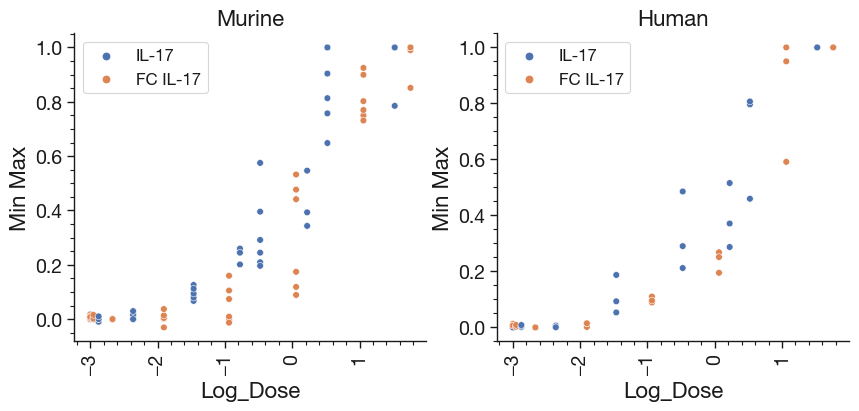

In [27]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x='Log_Dose',
              y='Min Max',
              hue='Molecule',
              data=data_df[data_df.Species=='Murine'],ax=ax1)
plt.title('Murine')
plt.legend(fontsize=12)
plt.xticks(rotation=90)

ax2 = plt.subplot(1,2,2)
sns.scatterplot(x='Log_Dose',
              y='Min Max',
              hue='Molecule',
              data=data_df[data_df.Species=='Human'],ax=ax2)
plt.title('Human')
plt.legend(fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Define Model Function

In [4]:
def sigmoid_1param(x,ec50):
    y = 1 / (1 + 10**(-1*(x-ec50)))
    return y

### Parameter Fitting for 1 parameter sigmoid curves

In [29]:
species = ['Murine','Human']
molecules = ['IL-17','FC IL-17']

fit_info = {}
for specie in species:
    data = data_df[data_df.Species==specie]
    fit_info[specie]={}
    for molecule in molecules:
        fit_info[specie][molecule] = {"popt":0,"pcov":0}
        popt , pcov = curve_fit(sigmoid_1param,
                                data[data.Molecule==molecule].Log_Dose,
                                data.loc[data.Molecule==molecule,'Min Max'])
        fit_info[specie][molecule]["popt"] = popt
        fit_info[specie][molecule]["pcov"] = pcov
        fit_info[specie][molecule]["perr"] = np.sqrt(np.diag(pcov))
        ### This obtains the 95% confidence intervals
        fit_info[specie][molecule]["perr+"] = popt + np.sqrt(np.diag(pcov))* 1.96
        fit_info[specie][molecule]["perr-"] =  popt - np.sqrt(np.diag(pcov))* 1.96


## Obtain values for mean and confidence intervals

In [58]:
plotting_info = {}
species = ['Murine','Human']
molecules = ['IL-17','FC IL-17']
weight = {'IL-17':35,'FC IL-17':86}

for specie in species:
    plotting_info[specie]={}
    for molecule in molecules:
        plotting_info[specie][molecule] = {}
        x_vals = np.linspace(-4, 2, 50)

        y1 = sigmoid_1param(x_vals,*fit_info[specie][molecule]["popt"])
        y2 = sigmoid_1param(x_vals,*fit_info[specie][molecule]["perr+"])
        y3 = sigmoid_1param(x_vals,*fit_info[specie][molecule]["perr-"])

        print(f"""{specie} {molecule}||\nEC50 (nM) = {np.round(10**fit_info[specie][molecule]["popt"][0],2)} \n
95% CI (nM): ({np.round(10**(fit_info[specie][molecule]["perr-"][0]),2)} - \
{np.round(10**(fit_info[specie][molecule]["perr+"][0]),2)}) \n
        """)

        print(f"""{specie} {molecule}||\nEC50 (ng/mL) = {np.round(10**fit_info[specie][molecule]["popt"][0] * weight[molecule],2)} \n
95% CI (ng/mL): ({np.round(10**(fit_info[specie][molecule]["perr-"][0])* weight[molecule],2)} - \
{np.round(10**(fit_info[specie][molecule]["perr+"][0])*weight[molecule],2)}) \n
        """)
        plotting_info[specie][molecule]['x'] = x_vals
        plotting_info[specie][molecule]['y'] = y1
        plotting_info[specie][molecule]['y+err'] = y2
        plotting_info[specie][molecule]['y-err'] = y3


        

Murine IL-17||
EC50 (nM) = 0.88 

95% CI (nM): (0.68 - 1.15) 

        
Murine IL-17||
EC50 (ng/mL) = 30.83 

95% CI (ng/mL): (23.67 - 40.14) 

        
Murine FC IL-17||
EC50 (nM) = 2.57 

95% CI (nM): (2.04 - 3.23) 

        
Murine FC IL-17||
EC50 (ng/mL) = 220.64 

95% CI (ng/mL): (175.16 - 277.92) 

        
Human IL-17||
EC50 (nM) = 1.61 

95% CI (nM): (1.13 - 2.3) 

        
Human IL-17||
EC50 (ng/mL) = 56.4 

95% CI (ng/mL): (39.56 - 80.42) 

        
Human FC IL-17||
EC50 (nM) = 2.83 

95% CI (nM): (2.04 - 3.94) 

        
Human FC IL-17||
EC50 (ng/mL) = 243.61 

95% CI (ng/mL): (175.02 - 339.09) 

        


## Generate the means and standard error of the means for plotting

In [40]:
means = data_df.groupby(['Species', 'Molecule','Dosage']).mean()
stds = data_df.groupby(['Species', 'Molecule','Dosage']).sem()

/var/folders/6n/m295x70529xbnpr1vzrwnk1w0000gn/T/ipykernel_61423/3499328048.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data_df.groupby(['Species', 'Molecule','Dosage']).mean()
/var/folders/6n/m295x70529xbnpr1vzrwnk1w0000gn/T/ipykernel_61423/3499328048.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = data_df.groupby(['Species', 'Molecule','Dosage']).sem()


## Plot Murine PD Curve

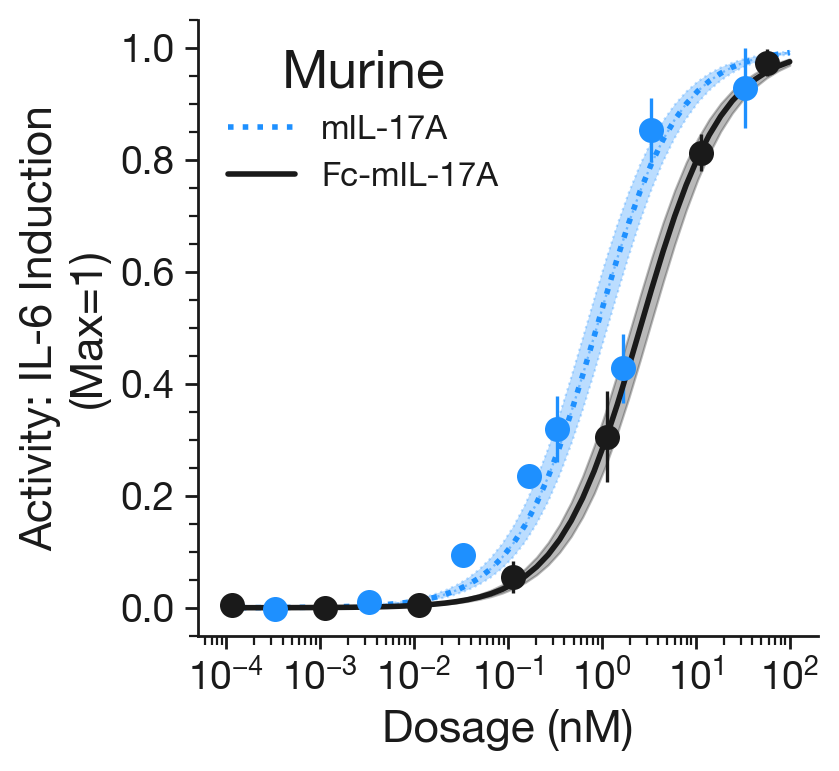

In [41]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 200)
style_dict = {'IL-17':{'linestyle':':',
                       'color':'dodgerblue',
                          'marker':'o'
                         },
              'FC IL-17':{'linestyle':'-',
                       'color':'k',
                       'marker':'o'
                      }
             }
label ={'FC IL-17':'Fc-mIL-17A',
        'IL-17':'mIL-17A',
             }
specie='Murine'
for molecule in molecules:
    ax.plot(10**plotting_info[specie][molecule]['x'],
            plotting_info[specie][molecule]['y'],
            label=f'{label[molecule]}', c =style_dict[molecule]['color'],
            linestyle = style_dict[molecule]['linestyle'],linewidth=2, )
    ax.errorbar(x=means.loc[(specie,molecule)].loc[:,'Min Max'].index,
                y=means.loc[(specie,molecule)].loc[:,'Min Max'],
                yerr = stds.loc[(specie,molecule)].loc[:,'Min Max'],
                linestyle='',marker=style_dict[molecule]['marker'],markersize=8,
                c =style_dict[molecule]['color'],
               )
    ax.fill_between(10**plotting_info[specie][molecule]['x'],
                    plotting_info[specie][molecule]['y'],
                    plotting_info[specie][molecule]['y-err'], 
                    alpha = 0.3, 
                    linestyle = style_dict[molecule]['linestyle'],
                    color =style_dict[molecule]['color'])
    ax.fill_between(10**plotting_info[specie][molecule]['x'],
                    plotting_info[specie][molecule]['y'],
                    plotting_info[specie][molecule]['y+err'], 
                    alpha = 0.3,
                    linestyle = style_dict[molecule]['linestyle'],
                    color =style_dict[molecule]['color'])
    plt.xscale('log')
plt.legend(frameon=False, 
           fontsize=12, 
           title = f'{specie}', loc='upper left')
plt.ylabel('Activity: IL-6 Induction\n(Max=1)')
plt.xlabel('Dosage (nM)')
plt.ylim([-0.05,1.05])
apply_log_scale_with_custom_ticks(ax)
plt.savefig(working_path+save_figures_path+ f"/{specie}_PD_Curve.pdf",
            bbox_inches="tight",dpi=200)

## Plot Human PD Curve

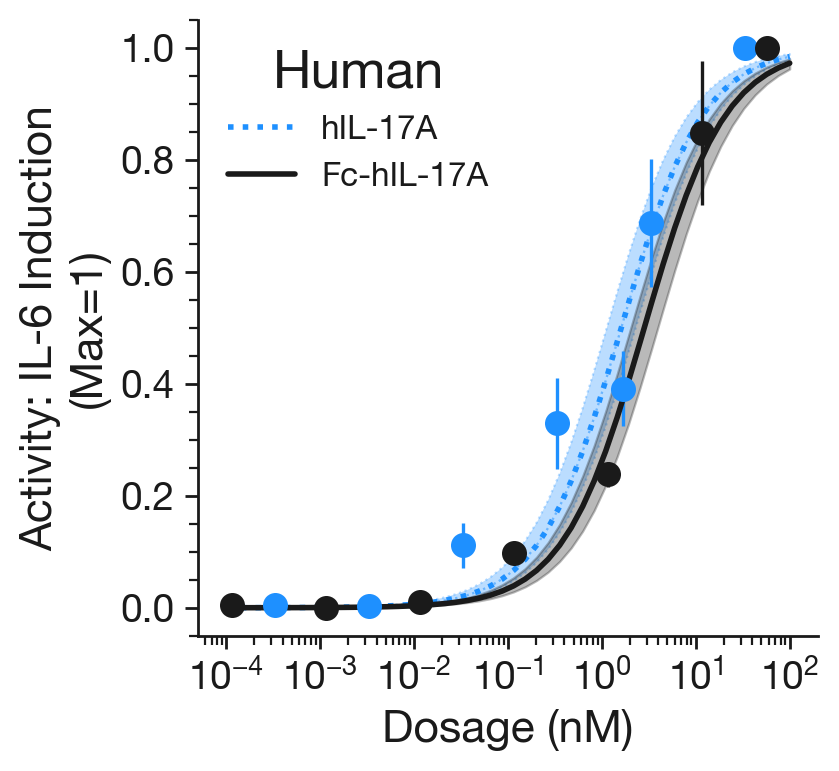

In [98]:
fig, ax = plt.subplots(figsize=(4,4),dpi = 200)

label ={'FC IL-17':'Fc-hIL-17A',
        'IL-17':'hIL-17A',
             }
specie='Human'
for molecule in molecules:
    ax.plot(10**plotting_info[specie][molecule]['x'],
            plotting_info[specie][molecule]['y'],
            label=f'{label[molecule]}', c =style_dict[molecule]['color'],
            linestyle = style_dict[molecule]['linestyle'],linewidth=2, )
    ax.errorbar(x=means.loc[(specie,molecule)].loc[:,'Min Max'].index,
                y=means.loc[(specie,molecule)].loc[:,'Min Max'],
                yerr = stds.loc[(specie,molecule)].loc[:,'Min Max'],
                linestyle='',marker=style_dict[molecule]['marker'],markersize=8,
                c =style_dict[molecule]['color'],
               )
    ax.fill_between(10**plotting_info[specie][molecule]['x'],
                    plotting_info[specie][molecule]['y'],
                    plotting_info[specie][molecule]['y-err'], 
                    alpha = 0.3, 
                    linestyle = style_dict[molecule]['linestyle'],
                    color =style_dict[molecule]['color'])
    ax.fill_between(10**plotting_info[specie][molecule]['x'],
                    plotting_info[specie][molecule]['y'],
                    plotting_info[specie][molecule]['y+err'], 
                    alpha = 0.3,
                    linestyle = style_dict[molecule]['linestyle'],
                    color =style_dict[molecule]['color'])
    plt.xscale('log')
plt.legend(frameon=False, fontsize=12, title = f'{specie}')
plt.ylabel('Activity: IL-6 Induction\n(Max=1)')
plt.xlabel('Dosage (nM)')
plt.ylim([-0.05,1.05])
apply_log_scale_with_custom_ticks(ax)
plt.savefig(working_path+save_figures_path+ f"/{specie}_PD_Curve.pdf",
            bbox_inches="tight",dpi=200)